# SmoothQuant Demonstration in Colab

### Paper Authors: Guangxuan Xiao\*, Ji Lin\*, Mickael Seznec, Julien Demouth, Song Han

### Present by: Kecen Yao & Zhichen Ren, 2025/3/21

This colab demonstrates the effect of SmoothQuant, a quantization technique designed to improve numerical stability and efficiency in deep learning models. **The primary goal of SmoothQuant is to redistribute outlier values from activations to weights, making both easier to quantize.** This is particularly useful in transformer-based architectures where extreme activation values can hinder effective low-bit quantization. We first show how to smooth the activation and the weight, then we demonstrate the result of smoothquant comparing to W8A8 quantization.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm



First, we simulate the activation and weight matrices.


*   Activation Matrix (X): We define X as a matrix with shape (30, 300), where 30 represents tokens (batch size) and 300 represents channels (features). The activations are randomly generated. To simulate real-world scenarios with outliers, we artificially scale up specific channels (50, 150, and 250) to introduce extreme values.
*  Weight Matrix (W): We define W as a matrix with shape (300, 75), where 300 corresponds to input channels and 75 represents output channels. Unlike X, the weight matrix is initialized with a lower variance to ensure that it remains well-distributed and is not significantly affected by outliers in the activation matrix.

In [ ]:
# Set parameters for visualization
num_tokens = 30  # Number of tokens (batch size)
num_channels = 300  # Number of channels (features)

# Generate activation matrix with outliers in specific channels
torch.manual_seed(42)
X = torch.randn(num_tokens, num_channels) * 2
outlier_channels = [50, 150, 250]  # Specific channels with large values
for ch in outlier_channels:
    X[:, ch] *= 50  # Create pronounced outliers

# Generate weight matrix with more realistic distribution
W = torch.randn(num_channels, num_channels // 4) * 0.5  # Smaller variance



Apply SmoothQuant scaling.

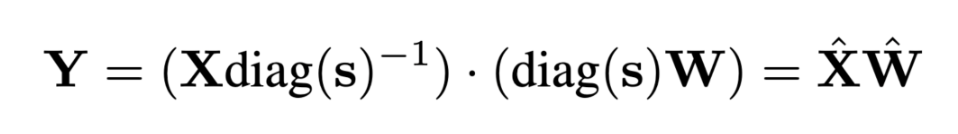

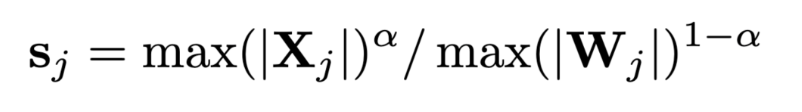

In [ ]:
# Apply SmoothQuant scaling as described in the paper
def smooth(activation, weight, alpha=0.5):
    # Calculate per-channel max values for better outlier handling
    activation_max = torch.max(torch.abs(X), dim=0, keepdim=True)[0]
    weight_max = torch.max(torch.abs(W), dim=1, keepdim=True)[0]
    weight_max = weight_max.view(1, -1)
    # Scale
    scale = torch.pow(activation_max, alpha) / torch.pow(weight_max, 1 - alpha)
    scale_matrix = torch.diagflat(scale)
    X_smooth = X @ scale_matrix.inverse()  # Scale activations
    W_smooth = scale_matrix @ W  # Scale weights properly
    return X_smooth, W_smooth

X_smooth, W_smooth = smooth(X, W)

We visualize the effect of Smoothquant.

<ipython-input-4-0ffb0fe4dea8>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


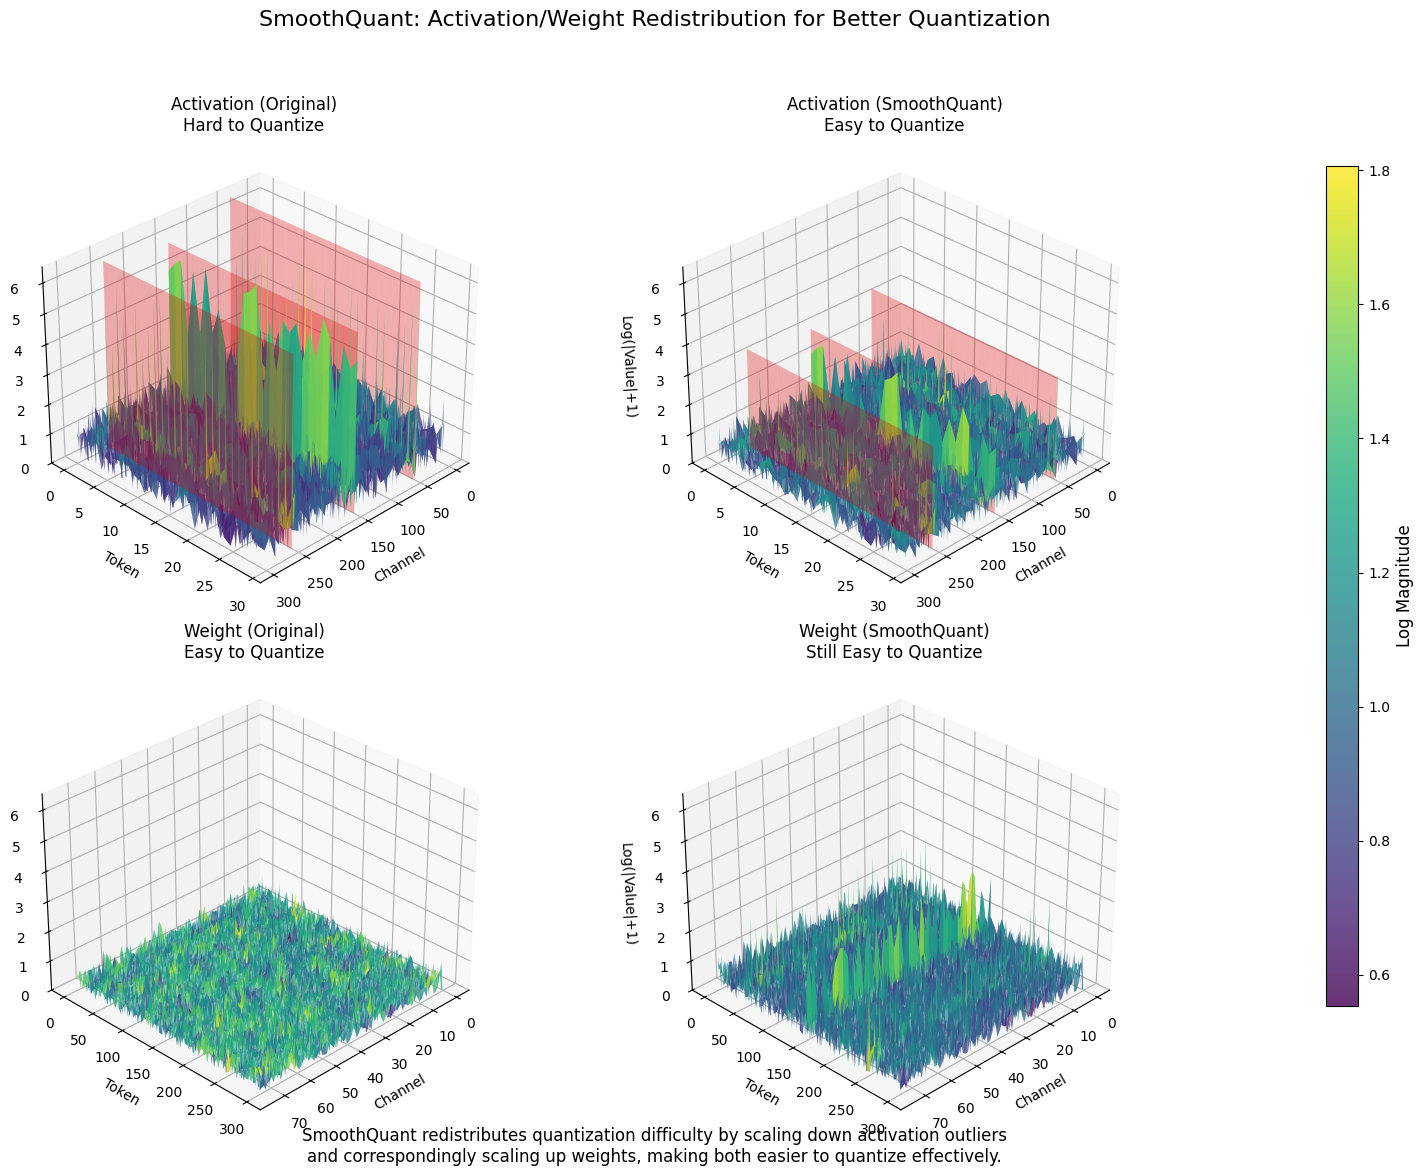

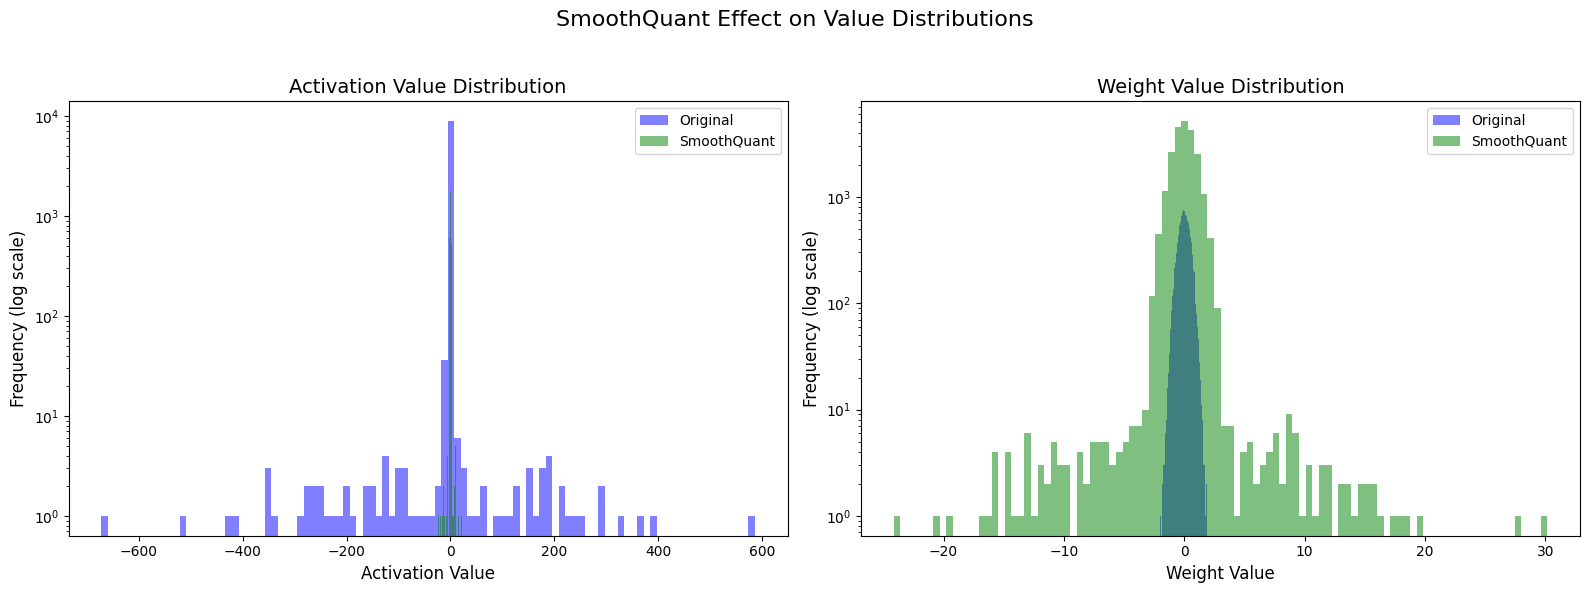

In [ ]:
# Create a unified figure for all plots
fig = plt.figure(figsize=(16, 12))

# Create 3D plots with the same scale and viewpoint
def add_3d_subplot(position, matrix, title, outliers=None):
    tokens, channels = matrix.shape
    X_grid, Y_grid = np.meshgrid(np.arange(channels), np.arange(tokens))

    ax = fig.add_subplot(position, projection='3d')

    # Use log scale for better visualization of outliers
    log_matrix = torch.log1p(torch.abs(matrix))

    # Plot surface with custom settings
    surf = ax.plot_surface(
        X_grid, Y_grid, log_matrix.numpy(),
        cmap=cm.viridis,
        linewidth=0,
        antialiased=True,
        alpha=0.8
    )

    # Highlight outlier channels
    if outliers is not None:
        for ch in outliers:
            x_plane = np.ones((tokens, 2)) * ch
            y_plane = np.vstack([np.arange(tokens), np.arange(tokens)]).T
            z_plane = np.zeros((tokens, 2))
            max_height = log_matrix[:, ch].max().item()
            z_plane[:, 0] = 0
            z_plane[:, 1] = max_height
            ax.plot_surface(x_plane, y_plane, z_plane, color='red', alpha=0.3)

    # Set consistent viewing angle for all plots
    ax.view_init(elev=30, azim=45)

    # Set the same zlim for all plots to ensure comparability
    ax.set_zlim(0, global_zlim)

    # Add labels and title
    ax.set_xlabel("Channel", fontsize=10)
    ax.set_ylabel("Token", fontsize=10)
    ax.set_zlabel("Log(|Value|+1)", fontsize=10)
    ax.set_title(title, fontsize=12)

    return surf

# Find global z limit for consistent scaling
global_zlim = max(
    torch.log1p(torch.abs(X)).max().item(),
    torch.log1p(torch.abs(X_smooth)).max().item(),
    torch.log1p(torch.abs(W)).max().item(),
    torch.log1p(torch.abs(W_smooth)).max().item()
)

# Add subplots for each matrix
surf1 = add_3d_subplot(221, X, "Activation (Original)\nHard to Quantize", outliers=outlier_channels)
surf2 = add_3d_subplot(222, X_smooth, "Activation (SmoothQuant)\nEasy to Quantize", outliers=outlier_channels)
surf3 = add_3d_subplot(223, W, "Weight (Original)\nEasy to Quantize")
surf4 = add_3d_subplot(224, W_smooth, "Weight (SmoothQuant)\nStill Easy to Quantize")

# Add a colorbar that applies to all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(surf1, cax=cbar_ax)
cbar.set_label("Log Magnitude", fontsize=12)

# Add a figure title explaining SmoothQuant
fig.suptitle("SmoothQuant: Activation/Weight Redistribution for Better Quantization",
             fontsize=16, y=0.98)

# Add a small text explanation
fig.text(0.5, 0.02,
         "SmoothQuant redistributes quantization difficulty by scaling down activation outliers\n"
         "and correspondingly scaling up weights, making both easier to quantize effectively.",
         ha='center', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])

# Add distribution comparison in a separate figure
fig2 = plt.figure(figsize=(16, 6))

# Plot activation distribution before and after
ax1 = fig2.add_subplot(121)
ax1.hist(X.flatten().numpy(), bins=100, alpha=0.5, label='Original', color='blue')
ax1.hist(X_smooth.flatten().numpy(), bins=100, alpha=0.5, label='SmoothQuant', color='green')
ax1.set_yscale('log')
ax1.set_xlabel('Activation Value', fontsize=12)
ax1.set_ylabel('Frequency (log scale)', fontsize=12)
ax1.set_title('Activation Value Distribution', fontsize=14)
ax1.legend()

# Plot weight distribution before and after
ax2 = fig2.add_subplot(122)
ax2.hist(W.flatten().numpy(), bins=100, alpha=0.5, label='Original', color='blue')
ax2.hist(W_smooth.flatten().numpy(), bins=100, alpha=0.5, label='SmoothQuant', color='green')
ax2.set_yscale('log')
ax2.set_xlabel('Weight Value', fontsize=12)
ax2.set_ylabel('Frequency (log scale)', fontsize=12)
ax2.set_title('Weight Value Distribution', fontsize=14)
ax2.legend()

fig2.suptitle('SmoothQuant Effect on Value Distributions', fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

## Quantization

Implements 8-bit quantization for activations and weights, comparing naïve quantization (W8A8) with SmoothQuant. We have prepare 3 set experiements,

One is when alpha = 0, with no smooth of activation and weight.

Second is when alpha = 0.5, we mitigate some difficulties from activation to weight.

Third is when alpha =1, we mitigate all the difficulties from activation to weight.

In [ ]:
# return the quantized tensor and scale (quantization step size in paper)
def quantize(tensor, num_bit=8):
    qmin = -2**(num_bit - 1)
    qmax = 2**(num_bit - 1) - 1

    scale = tensor.abs().max() / qmax

    quantized = torch.round(tensor / scale).clamp(qmin, qmax)
    return quantized.to(torch.int8), scale

def calculation(weight, activation, scale_w, scale_a):
    return activation.to(torch.int32) @ weight.to(torch.int32) * scale_w * scale_a

In [ ]:
# FP16 calculation
result = X @ W

print('Naive W8A8:')
# naive w8a8 quant
X_quant, scale_a = quantize(X)
print(f'Scale factor for activation: {scale_a}')
W_quant, scale_w = quantize(W)
print(f'Scale factor for weight: {scale_w}')
result_quant = calculation(W_quant, X_quant, scale_w, scale_a)
quant_error = torch.norm(result - result_quant) / torch.norm(result)
print(f'Normalized quantization error: {quant_error}\n')

print('SmoothQuant (alpha = 0.5):')
# smoothquant
X_smooth_quant, scale_a = quantize(X_smooth)
print(f'Scale factor for activation: {scale_a}')
W_smooth_quant, scale_w = quantize(W_smooth)
print(f'Scale factor for weight: {scale_w}')
result_smooth_quant = calculation(W_smooth_quant, X_smooth_quant, scale_w, scale_a)
smooth_quant_error = torch.norm(result - result_smooth_quant) / torch.norm(result)
print(f'Normalized quantization error: {smooth_quant_error}\n')

print('SmoothQuant (alpha = 1):')
# smoothquant migrate all difficulty
X_smooth_all, W_smooth_all = smooth(X, W, alpha=1)
X_smooth_quant, scale_a = quantize(X_smooth_all)
print(f'Scale factor for activation: {scale_a}')
W_smooth_quant, scale_w = quantize(W_smooth_all)
print(f'Scale factor for weight: {scale_w}')
result_smooth_quant = calculation(W_smooth_quant, X_smooth_quant, scale_w, scale_a)
smooth_quant_error = torch.norm(result - result_smooth_quant) / torch.norm(result)
print(f'Normalized quantization error: {smooth_quant_error}\n')


Naive W8A8:
Scale factor for activation: 5.293615818023682
Scale factor for weight: 0.015881001949310303
Normalized quantization error: 0.0792115181684494

SmoothQuant (alpha = 0.5):
Scale factor for activation: 0.23756477236747742
Scale factor for weight: 0.23756477236747742
Normalized quantization error: 0.013819285668432713

SmoothQuant (alpha = 1):
Scale factor for activation: 0.007874015718698502
Scale factor for weight: 7.167502403259277
Normalized quantization error: 0.08437575399875641



## Conlusion

We can see that the SmoothQuant model has a similar accuracy as the FP16 model, but it is faster and uses less memory. This is because SmoothQuant reduces the quantization difficulty of activations and enables the use of INT8 GEMM kernels.